# Emotional AI Chatbot Using Dorner's Psi Theory

This notebook explores the development of an emotional AI chatbot by integrating Dorner's Psi Theory for understanding and simulating emotional responses. It dynamically calculates and displays sadness and anger levels during a conversation, adapting its dialogue accordingly.

### Step 1:Importing Libraries

In [36]:
import logging
from typing import Dict
from langchain.memory import ConversationBufferMemory
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain
from flask import Flask, render_template, request, jsonify
from langchain.chains import ConversationChain
from langchain_core.language_models import BaseLLM
from pydantic import Field 
from langchain_core.outputs import LLMResult 
import matplotlib.pyplot as plt
from openai import OpenAI
from dotenv import load_dotenv
import os
import time

### Step 2: Define Emotional Model

#### Dorner's Psi Theory Parameters

In [31]:
# Valence: Spectrum of attraction vs. aversion (1-7).
# Arousal**: Readiness for action (1-7).
# Selection Threshold: Ease of intention shifting (1-7).
# Resolution**: Perceptual accuracy (1-7).
# Goal Directedness**: Stability of motives (1-7).

# Emotional State Calculation

def calculate_emotional_state(valence: float, arousal: float, selection_threshold: float, resolution: float, goal_directedness: float) -> Dict[str, float]:
    """
    Calculate the anger and sadness levels based on Dorner's Psi Theory parameters.

    Parameters:
        valence (float): Spectrum of attraction vs. aversion (1-7).
        arousal (float): Readiness for action (1-7).
        selection_threshold (float): Ease of intention shifting (1-7).
        resolution (float): Perceptual accuracy (1-7).
        goal_directedness (float): Stability of motives (1-7).

    Returns:
        dict: Calculated anger and sadness levels.
    """
    # Input validation
    if not all(1 <= param <= 7 for param in [valence, arousal, selection_threshold, resolution, goal_directedness]):
        raise ValueError("All parameters must be between 1 and 7.")

    # Calculate emotional states
    anger = max(0, (arousal * (7 - valence) * goal_directedness) / 35)
    sadness = max(0, ((7 - arousal) * (7 - goal_directedness)) / 49)

    return {
        "anger": round(min(anger, 5), 2),
        "sadness": round(min(sadness, 5), 2)
    }

In [32]:
# Test the function with example values
example_emotions = calculate_emotional_state(4, 6, 5, 4, 3)
print("Example Emotion Levels:", example_emotions)

Example Emotion Levels: {'anger': 1.54, 'sadness': 0.08}


### Step 3: Set Up the Chatbot
### Define Chatbot Logic Using OpenRouter and Google Gemini Model

In [37]:
# Configure logging for debugging and performance tracking
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Load environment variables from .env file
load_dotenv()

# Initialize LangChain's memory for conversation context
memory = ConversationBufferMemory()

# Configuration for OpenRouter API
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_BASE_URL = os.getenv("OPENROUTER_BASE_URL")

def initialize_chatbot():
    """Initialize the chatbot using OpenRouter with Google Gemini model."""
    client = OpenAI(
        base_url=OPENROUTER_BASE_URL,
        api_key=OPENROUTER_API_KEY,
    )

    class GeminiWrapper(BaseLLM):
        """Wrapper for the Google Gemini model using OpenRouter."""
        
        client: OpenAI = Field(...)  # Define 'client' as a field

        def __init__(self, client):
            super().__init__(client=client)  # Use super to initialize the parent class

        def _call(self, prompt: str, stop: None = None) -> str:
            """Invoke the Gemini model to get a response."""
            try:
                start_time = time.time()
                completion = self.client.chat.completions.create(
                    model="google/gemini-exp-1121:free",
                    messages=[{"role": "user", "content": prompt}]
                )
                logging.info(f"Response time: {time.time() - start_time:.2f}s")
                return completion.choices[0].message.content
            except Exception as e:
                logging.error(f"Error in API call: {e}")
                return "Sorry, I encountered an issue while processing your request."

        def _generate(self, prompts: list[str], stop: None = None) -> LLMResult:
            """Generate responses for multiple prompts."""
            generations = []
            for prompt in prompts:
                try:
                    response = self._call(prompt, stop)
                    generations.append([{"text": response}])
                except Exception as e:
                    logging.error(f"Error generating response for prompt '{prompt}': {e}")
                    generations.append([{"text": "An error occurred while processing your request."}])
            
            return LLMResult(generations=generations)

        @property
        def _identifying_params(self) -> dict:
            """Return identifying parameters for the LLM."""
            return {"model": "google/gemini-exp-1121:free"}

        @property
        def _llm_type(self) -> str:
            """Return type of LLM."""
            return "GeminiWrapper"

    # Initialize the GeminiWrapper instance
    gemini_llm = GeminiWrapper(client)

    # Initialize the ConversationChain
    chain = ConversationChain(llm=gemini_llm, memory=memory, verbose=True)
    return chain

chatbot = initialize_chatbot()

### Step 4: Simulate a Conversation
### Dynamic Emotional Response

In [38]:
def generate_chatbot_response(user_input: str, valence: float, arousal: float, selection_threshold: float, resolution: float, goal_directedness: float):
    """
    Generate a chatbot response based on the user's input and Psi Theory parameters.

    Parameters:
        user_input (str): The user's message.
        valence, arousal, selection_threshold, resolution, goal_directedness (float): Emotional parameters.

    Returns:
        dict: Chatbot response and updated emotional state.
    """
    # Calculate emotions
    emotions = calculate_emotional_state(valence, arousal, selection_threshold, resolution, goal_directedness)

    # Modify the chatbot's tone based on emotions
    if emotions["anger"] > 3:
        response_prefix = "[Assertive Mode] "
    elif emotions["sadness"] > 3:
        response_prefix = "[Empathy Mode] "
    else:
        response_prefix = "[Neutral Mode] "

    # Get chatbot response
    response = chatbot.run(user_input)

    return {
        "response": response_prefix + response,
        "emotions": emotions
    }

### Step 6: Visualizing Emotional Parameters
### Real-Time Emotion Display

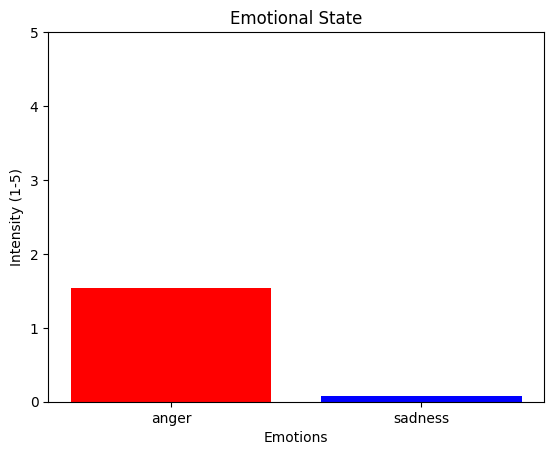

In [39]:
def plot_emotions(emotions):
    """Plot anger and sadness levels as a bar chart."""
    labels = list(emotions.keys())
    levels = list(emotions.values())

    plt.bar(labels, levels, color=['red', 'blue'])
    plt.ylim(0, 5)
    plt.xlabel("Emotions")
    plt.ylabel("Intensity (1-5)")
    plt.title("Emotional State")
    plt.show()

# Visualize example emotions
plot_emotions(example_emotions)

## Step 6: Example Usage

### Test Emotional State Calculation and Chatbot Interaction

Example Emotions: {'anger': 1.54, 'sadness': 0.08}


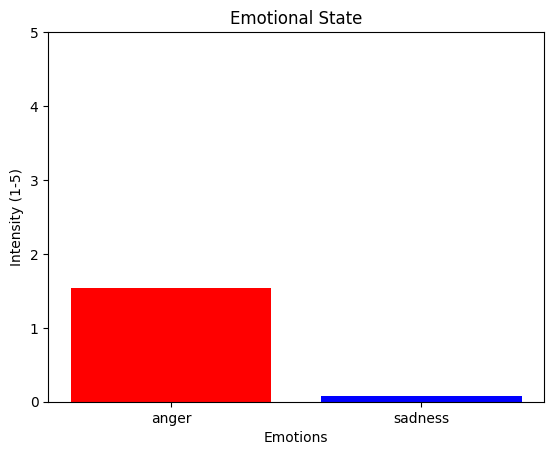



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Why do I feel so upset?
AI:


2025-01-27 16:04:11,014 - INFO - HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"
2025-01-27 16:04:11,448 - INFO - Response time: 1.25s
2025-01-27 16:04:11,449 - ERROR - Error in API call: 'NoneType' object is not subscriptable



> Finished chain.
Chatbot Response: [Neutral Mode] Sorry, I encountered an issue while processing your request.
Updated Emotions: {'anger': 1.54, 'sadness': 0.08}


In [40]:
if __name__ == "__main__":
    # Test emotional state calculation
    try:
        example_emotions = calculate_emotional_state(4, 6, 5, 4, 3)
        print("Example Emotions:", example_emotions)
        plot_emotions(example_emotions)
    except ValueError as e:
        print(e)

    # Simulate a chatbot response
    user_input = "Why do I feel so upset?"
    response_data = generate_chatbot_response(user_input, 4, 6, 5, 4, 3)
    print("Chatbot Response:", response_data["response"])
    print("Updated Emotions:", response_data["emotions"])